In [ ]:
#@title # Dataset Settings

#@markdown ## The avilable datasets are:
#@markdown * [Br35H](https://www.kaggle.com/datasets/ahmedhamada0/brain-tumor-detection) - 1500 nig, 1500 pos.
#@markdown * [huggingface](https://huggingface.co/datasets/PranomVignesh/MRI-Images-of-Brain-Tumor) - 1312 nig, 4057 pos.

import subprocess, sys, os, shutil, re, random
from os.path import exists
from os import remove, mkdir
from shutil import rmtree
from datetime import datetime

#@markdown The choosen dataset name (not case sensetive)
DATASET = "Br35H" # @param ["Br35H", "Huggingface", "afridirahman/brain-stroke-ct-image-dataset"] {allow-input: true}
#DATASET_DIR = "dataset" #@param {type:"string"}
SAMPLES_LIMT = 690 # @param {type:"slider", min:50, max:5000, step:5}
#@markdown If dataset is larger than the selected `SAMPLES_LIMIT` then split it and train the model on more then one step.
SPLIT_DATASET = True #@param {type:"boolean"}
# VALIDATION_PERSENTAGE = 0.17 #@param {type:"slider", min:0.1, max:0.7, step:0.01}
TESTING_PERSENTAGE = 0.3 #@param {type:"slider", min:0.1, max:0.7, step:0.01}
#@markdown Delete the old samples list from a previous run
CLEAN_RUN = True #@param {type:"boolean"}
AUGMENTED_TRAIN_SAMPLES = False #@param {type:"boolean"}
AUGMENTED_TEST_SAMPLES = False #@param {type:"boolean"}

_cwd = os.getcwd()
os.path.expanduser(_cwd)
env = os.environ.copy()
env['HOME'] = _cwd

# if exists(DATASET_DIR) and CLEAN_RUN:
#   rmtree(DATASET_DIR)
# if not exists(DATASET_DIR):
#   mkdir(DATASET_DIR)

if CLEAN_RUN:
  SAMPLES = [[]]

img_pattern = re.compile(r'\.(png|jpg)$', re.IGNORECASE)

def copy_samples(source_directory: str) -> list[str]:
  # DIST_DIR = DATASET_DIR + "/" + dist
  # if not exists(DIST_DIR):
  #   os.mkdir(DIST_DIR)
    files = [source_directory + "/" + file for file in os.listdir(source_directory) if img_pattern.search(file)]
    return files
    # for i, src_file in enumerate(files):
    #   _, file_extension = os.path.splitext(src_file)
    #   dist = f"{DIST_DIR}/{DATASET}_{i}_{int(datetime.timestamp(datetime.now()))}{file_extension}"
    #   shutil.copy(os.path.join(source_directory, src_file), dist)


def cmd(cmd: str, _capture=True, _cwd=_cwd, _env=env) -> str:
  if _capture:
    result = subprocess.run(cmd, shell=True, capture_output=True, cwd = _cwd, env=_env, text=True)
  else:
    result = subprocess.run(cmd, shell=True, cwd = _cwd, env=_env, text=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
  try:
    result.check_returncode()
    if _capture:
      print(f"{result.stdout}")
    return result.stdout

  except subprocess.CalledProcessError:
    print(f"{result.stderr}\n", file=sys.stderr)
    raise Exception(f"Enconter an error while running `{cmd}`")

def download_kaggle_ds(target: str, ds: str):
  ZIP_NAME = ds.split('/')[-1] + ".zip"
  print(ZIP_NAME)
  if exists(target):
        rmtree(target)
  if not exists(ZIP_NAME):
    if not exists("/content/.kaggle/kaggle.json"):
      print("Plese upload your kaggle API token.\n")
      from google.colab import files
      files.upload()
      mkdir(".kaggle")
      cmd("mv /content/kaggle.json .kaggle")
      cmd("chmod 600 .kaggle/kaggle.json")
    cmd(f"kaggle datasets download -d {ds}", False)
  cmd(f"unzip {ZIP_NAME} -d {target}", False)

def br35h():
  DIR = "br35h"
  download_kaggle_ds(DIR, "ahmedhamada0/brain-tumor-detection")
  return (copy_samples(DIR + "/" + "no"),  copy_samples(DIR + "/" + "yes"))

POSITIVE_SAMPLES = []
NIGATIVE_SAMPLES = []

match DATASET.lower():
  case "br35h":
    n, y = br35h()
    NIGATIVE_SAMPLES.extend(n)
    POSITIVE_SAMPLES.extend(y)

  case "huggingface":
    DIR = "huggingface"
    if not exists(DIR):
      cmd(f"git clone --depth=1 https://huggingface.co/datasets/PranomVignesh/MRI-Images-of-Brain-Tumor.git {DIR}")
    DIR = f"{DIR}/timri"
    for topdir in ["test", "valid", "train"]:
      dir = f"{DIR}/{topdir}"
      for ydir in ["glioma", "meningioma", "pituitary"]:
        POSITIVE_SAMPLES.extend(copy_samples(f"{dir}/{ydir}"))
      NIGATIVE_SAMPLES.extend(copy_samples(f"{dir}/no-tumor"))

  case "afridirahman/brain-stroke-ct-image-dataset":
    DIR = "BS"
    download_kaggle_ds(DIR, "afridirahman/brain-stroke-ct-image-dataset")
    cmd(f"mv {DIR}/Brain_Data_Organised/* {DIR}")
    NIGATIVE_SAMPLES.extend(copy_samples(DIR + "/" + "Normal"))
    POSITIVE_SAMPLES.extend(copy_samples(DIR + "/" + "Stroke"))

  case _:
    raise ValueError("The choosen database dosn't exist")


print(f"Total pisitive samples: {len(POSITIVE_SAMPLES)}")
print(f"Total nigative samples: {len(NIGATIVE_SAMPLES)}")

# Shuffle our data
SAMPLES[0].extend([(path, 1) for path in POSITIVE_SAMPLES])
SAMPLES[0].extend([(path, 0) for path in NIGATIVE_SAMPLES])
random.shuffle(SAMPLES[0])

# Split our samples or chrink them if needed
def chunk_list(lst, chunk_size):
    return [lst[i:i + chunk_size] for i in range(0, len(lst), chunk_size)]

if len(SAMPLES[0]) > SAMPLES_LIMT:
  if SPLIT_DATASET:
    SAMPLES = chunk_list(SAMPLES[0], SAMPLES_LIMT)
    print(f"Samples has chanked into: {len(SAMPLES)} chunk")
  else:
    SAMPLES[0] = SAMPLES[:SAMPLES_LIMT]


brain-tumor-detection.zip
Plese upload your kaggle API token.



Saving kaggle.json to kaggle.json


Total pisitive samples: 1500
Total nigative samples: 1500
Samples has chanked into: 5 chunk


## Import Necessary Modules

In [ ]:
import tensorflow as tf
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir

%matplotlib inline

## Data Preparation & Preprocessing

In [ ]:
#@title Edges Crop
#@markdown In order to crop the part that contains only the brain of the image,
#@markdown We used a cropping technique to find the extreme top, bottom, left and right points
#@markdown of the brain. You can read more about it here [Finding extreme points in contours with OpenCV](https://www.pyimagesearch.com/2016/04/11/finding-extreme-points-in-contours-with-opencv/).

def crop_brain_contour(image, plot=False):
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)


    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)

        plt.tick_params(axis='both', which='both',
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Original Image')

        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both',
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')

        plt.show()

    return new_image

### Load up the data:

The following function takes two arguments, the first one is a list of directory paths for the folders 'yes' and 'no' that contain the image data and the second argument is the image size, and for every image in both directories and does the following:
1. Read the image.
2. Crop the part of the image representing only the brain.
3. Resize the image (because the images in the dataset come in different sizes (meaning width, height and # of channels). So, we want all of our images to be (240, 240, 3) to feed it as an input to the neural network.
4. Apply normalization because we want pixel values to be scaled to the range 0-1.
5. Append the image to <i>X</i> and its label to <i>y</i>.<br>

After that, Shuffle <i>X</i> and <i>y</i>, because the data is ordered (meaning the arrays contains the first part belonging to one class and the second part belonging to the other class, and we don't want that).<br>
Finally, Return <i>X</i> and <i>y</i>.

In [ ]:
#@title Prepare images and resize them

WIDTH = 340 #@param {type:"number"}
HEIGHT = 340 #@param {type:"number"}


def load_data(sampels_list):
    """
    Returns:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """
    x = []
    y = []
    for filename, y_val in sampels_list:
        #print(f"file: {filename}")
        # load the image
        image = cv2.imread(filename)
        #print(f"Cropping {image}")
        # crop the brain and ignore the unnecessary rest part of the image
        image = crop_brain_contour(image, plot=False)
        # resize image
        image = cv2.resize(image, dsize=(WIDTH, HEIGHT), interpolation=cv2.INTER_CUBIC)
        # normalize values
        image = image / 255.
        # convert image to numpy array and append it to X
        x.append(image)
        y.append([y_val])

    x = np.array(x)
    y = np.array(y)

    # Shuffle the data
    # x, y = shuffle(X, y)
    return x, y


def plot_sample_images(X, y, n=50):
    """
    Plots n sample images for both values of y (labels).
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """

    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]

        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))

        i = 1 # current plot
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])

            # remove ticks
            plt.tick_params(axis='both', which='both',
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)

            i += 1

        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()


Load up the data that we augmented earlier in the Data Augmentation notebook.<br>
**Note:** the augmented data directory contains not only the new generated images but also the original images.

In [ ]:
#@title Build the model

from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.optimizers.experimental import Adagrad, Nadam, RMSprop, SGD, Adamax
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau

#@markdown Please refer to: https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
OPTIMIZER = "AdamW" #@param ["Adam", "AdamW", "Adagrad", "Nadam", "RMSprop", "SGD", "Adamax"] {type:"string", allow-input: true}
#@markdown AdamW's default learning rate is often 0.001, but in practice, values between 0.0001 and 0.01 are commonly used.
LEARNING_RATE = 0.0001 #@param {type:"number"}
DECAY = True #@param {type:"boolean"}
WEIGTH_DECAY = 0.01 #@param {type:"number"}

match OPTIMIZER:
  case "Adam":
    OPTIMIZER = Adam(learning_rate=LEARNING_RATE)
  case "Adagrad":
      OPTIMIZER = Adagrad(learning_rate=LEARNING_RATE)
  case "AdamW":
      OPTIMIZER = AdamW(learning_rate=LEARNING_RATE)
  case "Nadam":
      OPTIMIZER = Nadam(learning_rate=LEARNING_RATE)
  case "RMSprop":
      OPTIMIZER = RMSprop(learning_rate=LEARNING_RATE)
  case "SGD":
      OPTIMIZER = SGD(learning_rate=LEARNING_RATE)
  case "Adamax":
      OPTIMIZER = Adamax(learning_rate=LEARNING_RATE)
  case _:
    raise ValueError("The choosen optimizer dosn't exist")

if DECAY:
  OPTIMIZER.weight_decay = WEIGTH_DECAY

# reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.01, patience=2, min_lr=1e-6)

def build_model(input_shape):
    """
    Arugments:
        input_shape: A tuple representing the shape of the input of the model. shape=(image_width, image_height, #_channels)
    Returns:
        model: A Model object.
    """
    # Define the input placeholder as a tensor with shape input_shape.
    X_input = Input(input_shape)

    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((2, 2))(X_input) # shape=(?, 244, 244, 3)

    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X) # shape=(?, 238, 238, 32)

    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool0')(X) # shape=(?, 59, 59, 32)

    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool1')(X) # shape=(?, 14, 14, 32)

    # FLATTEN X
    X = Flatten()(X) # shape=(?, 6272)
    # FULLYCONNECTED
    X = Dense(1, activation='sigmoid', name='fc')(X) # shape=(?, 1)

    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='BrainDetectionModel')

    return model

IMG_SHAPE = (WIDTH, HEIGHT, 3)
model = build_model(IMG_SHAPE)
model.summary()

print("Model compiling...")
model.compile(optimizer=OPTIMIZER, loss='binary_crossentropy', metrics=['accuracy'])

# tensorboard
log_file_name = f'brain_tumor_detection_cnn_{int(time.time())}'
tensorboard = TensorBoard(log_dir=f'logs/{log_file_name}')

# checkpoint
# unique file name that will include the epoch and the validation (development) accuracy
filepath="cnn-parameters-improvement-{epoch:02d}"
# save the model with the best validation (development) accuracy till now
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max'))

Model: "BrainDetectionModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 340, 340, 3)]     0         
                                                                 
 zero_padding2d (ZeroPaddin  (None, 344, 344, 3)       0         
 g2D)                                                            
                                                                 
 conv0 (Conv2D)              (None, 338, 338, 32)      4736      
                                                                 
 bn0 (BatchNormalization)    (None, 338, 338, 32)      128       
                                                                 
 activation (Activation)     (None, 338, 338, 32)      0         
                                                                 
 max_pool0 (MaxPooling2D)    (None, 84, 84, 32)        0         
                                               

In [ ]:
#@title Traning

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

EPOCHS = 32 #@param {type:"number"}
#@markdown Try powers of 2 (16, 32, 64, 128, etc.) to find the optimal balance for your specific problem and hardware.
BATCH_SIZE = 64 #@param{type:"number"}

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"

def split_data(X, y, test_size=0.2):
    """
    Splits data into training, development and test sets.
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    Returns:
        X_train: A numpy array with shape = (#_train_examples, image_width, image_height, #_channels)
        y_train: A numpy array with shape = (#_train_examples, 1)
        X_test: A numpy array with shape = (#_test_examples, image_width, image_height, #_channels)
        y_test: A numpy array with shape = (#_test_examples, 1)
    """

    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

    return x_train, y_train, x_test, y_test

def compute_f1_score(y_true, prob):
    # convert the vector of probabilities to a target vector
    y_pred = np.where(prob > 0.5, 1, 0)

    score = f1_score(y_true, y_pred)

    return score

for i, images_list in enumerate(SAMPLES[:3]):
  print(f"Chunk {i}:")
  x, y = load_data(images_list)
  print(f"\t x shape: {x.shape}, y shape: {y.shape}")
  print(f"\t Split the chunk into:")
  x_train, y_train, x_test, y_test = split_data(x,y, TESTING_PERSENTAGE)
  print(f"\t\t Number of training examples: {x_train.shape[0]}")
  print(f"\t\t Number of test examples: {x_test.shape[0]}")
  print(f"\t\t x_train shape: {x_train.shape}")
  print(f"\t\t y_train shape: {y_train.shape}")
  print(f">>> Traning on chanck {i} starts")
  start_time = time.time()
  model.fit(x=x_train, y=y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(x_test, y_test), callbacks=[tensorboard, checkpoint])
  end_time = time.time()
  execution_time = (end_time - start_time)
  print(f"Elapsed time: {hms_string(execution_time)}")

Chunk 0:
	 x shape: (690, 340, 340, 3), y shape: (690, 1)
	 Split the chunk into:
		 Number of training examples: 483
		 Number of test examples: 207
		 x_train shape: (483, 340, 340, 3)
		 y_train shape: (483, 1)
>>> Traning on chanck 0 starts
Epoch 1/32
8/8 [==============================] - 12s 731ms/step - loss: 1.1363 - accuracy: 0.5321 - val_loss: 0.6949 - val_accuracy: 0.5362
Epoch 2/32
8/8 [==============================] - 3s 373ms/step - loss: 0.7473 - accuracy: 0.5590 - val_loss: 0.6909 - val_accuracy: 0.5507
Epoch 3/32
8/8 [==============================] - 3s 401ms/step - loss: 0.6738 - accuracy: 0.6025 - val_loss: 0.6856 - val_accuracy: 0.5700
Epoch 4/32
8/8 [==============================] - 4s 487ms/step - loss: 0.6026 - accuracy: 0.6563 - val_loss: 0.6799 - val_accuracy: 0.5990
Epoch 5/32
8/8 [==============================] - 4s 539ms/step - loss: 0.5697 - accuracy: 0.6957 - val_loss: 0.6792 - val_accuracy: 0.5652
Epoch 6/32
8/8 [==============================] - 4s 5

In [ ]:
model.export("model.keras")

Saved artifact at 'model.keras'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 340, 340, 3), dtype=tf.float32, name='input_1')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  139853454596352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139853454595120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139853454598816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139853454603040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139853454604272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139853454605504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139853454603568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139853454605680: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [ ]:
!tar -cvf model.tar model.keras/

model.keras/
model.keras/fingerprint.pb
model.keras/saved_model.pb
model.keras/assets/
model.keras/variables/
model.keras/variables/variables.index
model.keras/variables/variables.data-00000-of-00001


In [ ]:
!xz model.tar

In [ ]:
history = model.history.history

## Plot Loss & Accuracy

In [ ]:
def plot_metrics(history):

    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']

    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()

    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

**Note:** Since we trained the model using more than model.fit() function call, this made the history only contain the metric values of the epochs for the last call (which was for 5 epochs), so to plot the metric values across the whole process of trianing the model from the beginning, I had to grab the rest of the values.

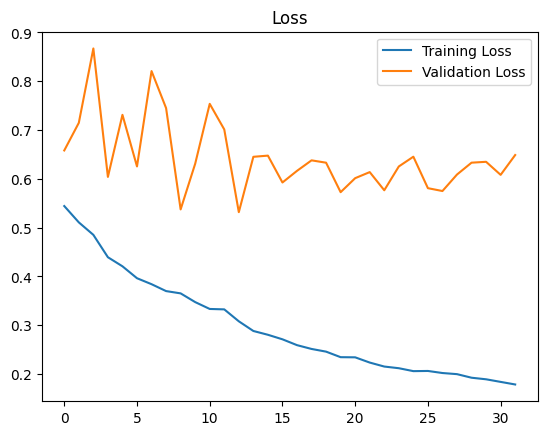

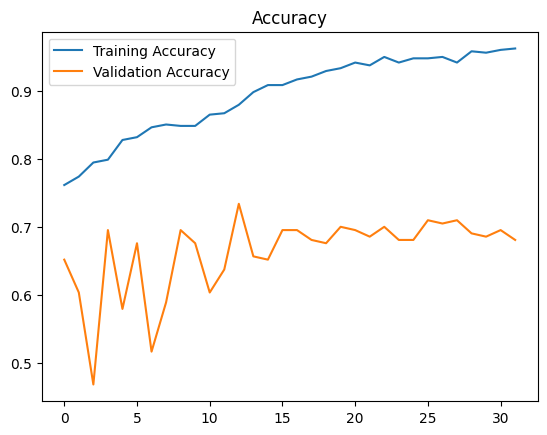

In [ ]:
#display(history)
plot_metrics(history)

# Results

Let's experiment with the best model (the one with the best validation accuracy):

In [ ]:
#@title Evaluaton
#@markdown The avilable datasets are:
#@markdown * [k1](https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection) - 253 samples.
EVALUATION_DATASET = "k1" #@param ["k1", "br35h"] {allow-input: true}

SAMPLES = []

match EVALUATION_DATASET:
  case "k1":
    DIR = "eval_data"
    download_kaggle_ds(DIR, "navoneel/brain-mri-images-for-brain-tumor-detection")
    rmtree(f"{DIR}/brain_tumor_dataset")
    SAMPLES.extend([(path, 0) for path in copy_samples(f"{DIR}/no")])
    SAMPLES.extend([(path, 1) for path in copy_samples(f"{DIR}/yes")])

  case "br35h":
    n, y = br35h()
    SAMPLES.extend([(path, 0) for path in n])
    SAMPLES.extend([(path, 1) for path in y])

  case _:
    raise ValueError("The choosen database dosn't exist")

print(f"Number of evaluation samples {len(SAMPLES)}")

SAMPLES = chunk_list(SAMPLES, 1000)

random.shuffle(SAMPLES)

brain-mri-images-for-brain-tumor-detection.zip
Number of evaluation samples 247


### Load the best model

In [ ]:
best_model = load_model(filepath=f"models/cnn-parameters-improvement-{EPOCHS}.model")

In [ ]:
best_model.metrics_names

['loss', 'accuracy']

Evaluate the best model on the testing data:

In [ ]:
total_loss = 0.0
total_acc = 0.0
for samples in SAMPLES:
  x_eval, y_eval = load_data(samples)
  print(f"x_eval shape: {x_eval.shape}")
  print(f"y_eval shape: {y_eval.shape}")
  loss, acc = best_model.evaluate(x=x_eval, y=y_eval)
  total_loss += loss
  total_acc += acc

print (f"Evaluation Loss = {total_loss}")
print (f"Evaluation Accuracy = {total_acc}")

x_eval shape: (247, 340, 340, 3)
y_eval shape: (247, 1)
8/8 [==============================] - 1s 94ms/step - loss: 0.2041 - accuracy: 0.9231
Evaluation Loss = 0.20405875146389008
Evaluation Accuracy = 0.9230769276618958


### F1 score for the best model on the testing data:

In [ ]:
y_eval_prop = best_model.predict(x_eval)

8/8 [==============================] - 0s 44ms/step


In [ ]:
f1score = compute_f1_score(y_eval, y_eval_prop)
print(f"F1 score: {f1score}")

F1 score: 0.9396825396825398


### Results Interpretation

Let's remember the percentage of positive and negative examples:

In [ ]:
def data_percentage(y):

    m=len(y)
    n_positive = np.sum(y)
    n_negative = m - n_positive

    pos_prec = (n_positive* 100.0)/ m
    neg_prec = (n_negative* 100.0)/ m

    print(f"Number of examples: {m}")
    print(f"Percentage of positive examples: {pos_prec}%, number of pos examples: {n_positive}")
    print(f"Percentage of negative examples: {neg_prec}%, number of neg examples: {n_negative}")



In [ ]:
# the whole data
data_percentage(y)

Number of examples: 465
Percentage of positive examples: 48.81720430107527%, number of pos examples: 227
Percentage of negative examples: 51.18279569892473%, number of neg examples: 238


In [ ]:
print("Training Data:")
data_percentage(y_train)
print("Validation Data:")
data_percentage(y_val)
print("Testing Data:")
data_percentage(y_test)

Training Data:
Number of examples: 420
Percentage of positive examples: 51.42857142857143%, number of pos examples: 216
Percentage of negative examples: 48.57142857142857%, number of neg examples: 204
Validation Data:
Number of examples: 90
Percentage of positive examples: 50.0%, number of pos examples: 45
Percentage of negative examples: 50.0%, number of neg examples: 45
Testing Data:
Number of examples: 90
Percentage of positive examples: 43.333333333333336%, number of pos examples: 39
Percentage of negative examples: 56.666666666666664%, number of neg examples: 51


As expectred, the percentage of positive examples are around 50%.